In [ ]:
import torch
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from torch import nn
print(torch.__version__)

2.1.0+cu121


#3. Workflow

##3.1) Data

ML is a game of 2 parts
1. input -convert-> numerical rep
2. build a model to learn patterns in that numerical rep


In [ ]:
#known params
weight = 0.7
bias = 0.3

#range of nos
start=0
end=1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

visualize data

In [ ]:
def plot_preds(train_data=X_train,
               train_labels=y_train,
               test_data=X_test,
               test_labels=y_test,
               preds=None):
  plt.figure(figsize=(12,5))

  #train data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  #test data in red
  plt.scatter(test_data, test_labels, c='r', s=4, label='Test data')

  if preds is not None:
    plt.scatter(test_data, preds, c='g', s=4, label='Predictions')

  plt.legend()

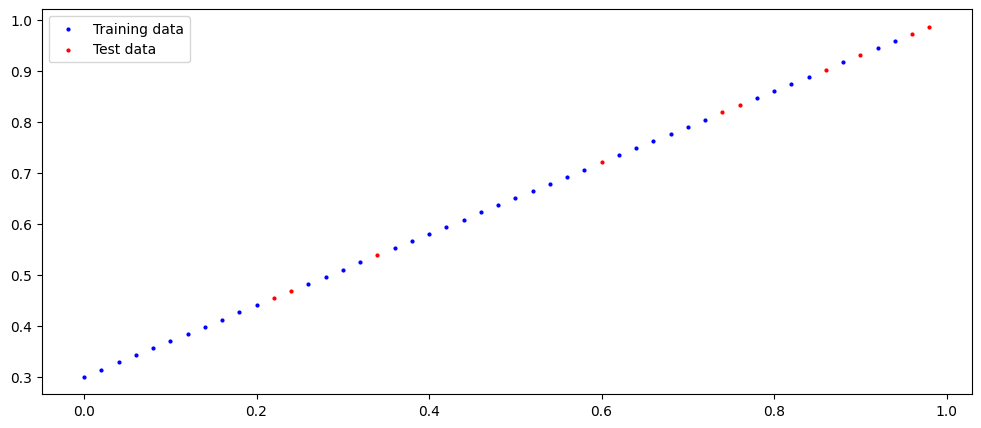

In [ ]:
plot_preds()

##3.2) build model

**Pytorch Model building essentials:**
1. `torch.nn`
  >building block of NNs

2. `torch.nn.Parameter`
  >to init params to be learnt by our model

3. `torch.nn.Module`
  >base class for all NN modules

  >should override `forward()` in subclass

4. `torch.optim`
  >where optimizers in PyTorch live

  >help optimize model params -> Gradient Descent

In [ ]:
#lr model
class LinearRegressionModel(nn.Module):
  #constructor
  def __init__(self):
    #super()
      # - inherits properties and methods (param management,
      #   forward method implementation, ...) from nn.Module class
    super().__init__()

    #init model params -> tensor
    self.weights = nn.Parameter(torch.rand(1,
                                           requires_grad=True,
                                           dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  #forward pass
  #any subclass of nn.Module needs to override forward()
  def forward(self, x:torch.Tensor):
    return self.weights * x + self.bias #lr formula

###***init model***

In [ ]:
#random seed
torch.manual_seed(42)

#instance of the model
model_0 = LinearRegressionModel()

###learnable params

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([-0.6382], requires_grad=True)]

###`state_dict()`
* a dict that maps each layer to its param tensor
* only shows layers with learnable params

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([-0.6382]))])

###prediction using `torch.inference_mode()`

* disables gradient tracking
* keeps track of less info -> faster pred
* can also use `torch.no_grad()`

In [ ]:
with torch.inference_mode():
  y_pred = model_0(X_test)

y_pred

tensor([[ 0.1559],
        [ 0.2265],
        [ 0.2088],
        [ 0.0147],
        [ 0.1206],
        [-0.4264],
        [ 0.0324],
        [-0.1088],
        [-0.4441],
        [-0.3382]])

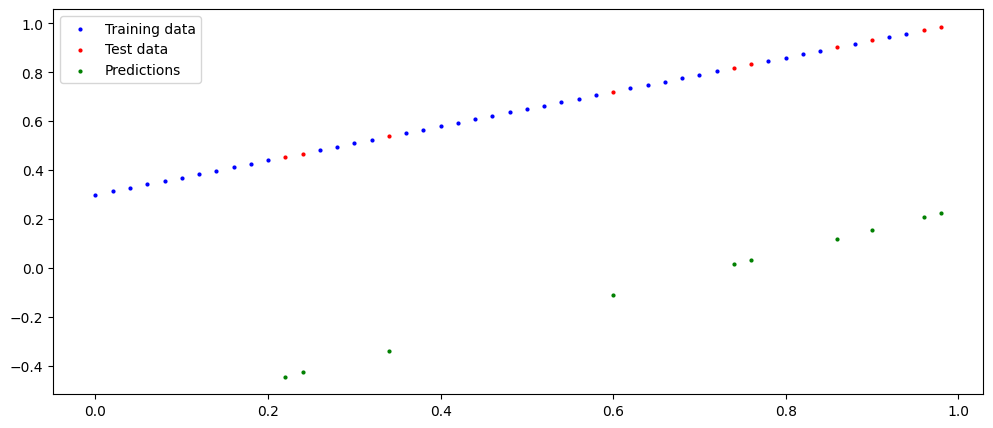

In [ ]:
plot_preds(preds=y_pred)

##3.3) Train model

1. **Loss func:** measures how far preds are from targets
2. **Optimizer:** adjusts the model's params s.t. it reduces the loss-> `torch.optim`

In [ ]:
#init loss func
loss_fn = nn.L1Loss()

#init optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.01) #lr(learning rate)


##3.4) Training and Testing loop
1. **forward pass**
2. **loss calc**
3. **optimizer zero grad** ⟶ prevents accumulation of gradients *(only train)*
4. **backpropagation** ⟶ calc gradients of each of the params w.r.t loss *(only train)*
5. **optimizer step** ⟶ use optimizer to reduce the loss by adjusting model params *(only train)*

In [ ]:
epoch_count = []
loss_log = []
test_loss_log = []
epochs=100
for epoch in range(epochs):
  ###Training loop

  #set model to train mode
    # - #sets all parameters that require gradients to accept gradients
    # - layers like dropout and batch normalization are activated
  model_0.train()

  #1. forward pass
  y_pred = model_0(X_train)

  #2. loss calc
  loss = loss_fn(y_pred, y_train)

  #3. optimizer zero grad
  optimizer.zero_grad()

  #4. backpropagation
  loss.backward()

  #5. gradient descent
  optimizer.step()
  #--------------------------------------------------------------

  ###Testing loop

  #eval mode
    # - layers like dropout and batch normalization are deactivated
  model_0.eval()
  # inference mode
  with torch.inference_mode():
    #1. forward pass
    y_test_pred = model_0(X_test)

    #2. loss calc
    test_loss = loss_fn(y_test_pred, y_test)

  if epoch%10==0:
    #logging results
    epoch_count.append(epoch)
    loss_log.append(loss)
    test_loss_log.append(test_loss)
    print(f'epoch {epoch}: loss={loss:.2f} | test_loss={test_loss:.2f}')

epoch 0: loss=0.86 | test_loss=0.80
epoch 10: loss=0.74 | test_loss=0.68
epoch 20: loss=0.62 | test_loss=0.55
epoch 30: loss=0.50 | test_loss=0.42
epoch 40: loss=0.38 | test_loss=0.29
epoch 50: loss=0.26 | test_loss=0.16
epoch 60: loss=0.16 | test_loss=0.10
epoch 70: loss=0.13 | test_loss=0.11
epoch 80: loss=0.11 | test_loss=0.12
epoch 90: loss=0.11 | test_loss=0.13


In [ ]:
print(f'optimal params: weights:{weight:.2f}, bias:{bias:.2f}')
print(f'adjusted params: {model_0.state_dict()}')

optimal params: weights:0.70, bias:0.30
adjusted params: OrderedDict([('weights', tensor([1.1208])), ('bias', tensor([0.0868]))])


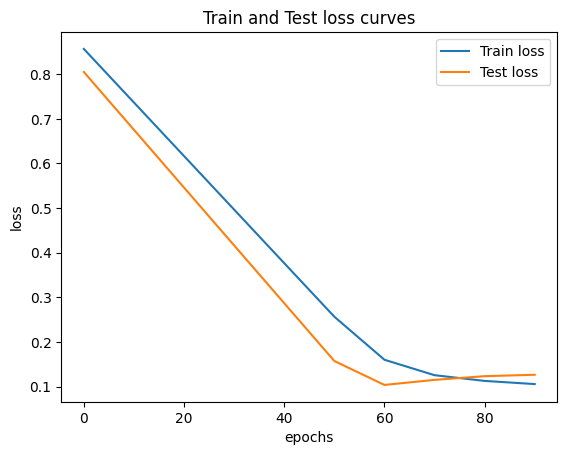

In [ ]:
plt.plot(epoch_count, np.array(torch.tensor(loss_log).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_log, label='Test loss')

plt.title('Train and Test loss curves')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

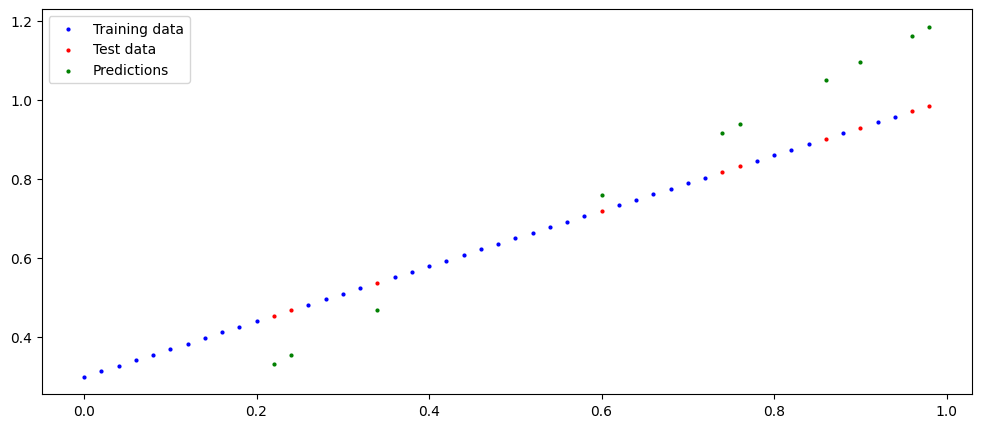

In [ ]:
plot_preds(preds=y_test_pred)

##3.5) Saving and Loading model
* `torch.save()` ⟶ to save a PyTorch obj in pickle format
* `torch.save()` ⟶ to load a saved PyTorch obj
* `torch.nn.Module.load_state_dict()` ⟶ to load a model's saved state dict

###Saving Model's `state_dict()`

In [ ]:
from pathlib import Path

#1. setup models dir
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. create model save path
MODEL_NAME = '02_PyTorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

#3. save model state_dict
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)
print('model saved successfully')

model saved successfully


In [ ]:
!ls -l models

total 8
-rw-r--r-- 1 root root 1744 Mar  4 04:49 01_PyTorch_workflow_model_1.pth
-rw-r--r-- 1 root root 1680 Mar  4 04:52 02_PyTorch_workflow_model_0.pth


###Loading Model's `state_dict()`

In [ ]:
#1. init a new instance of our model class before loading state_dict
loaded_model_0 = LinearRegressionModel()

print('before loading:')
print(loaded_model_0.state_dict())
print('\n')

#2. load the saved state_dict of model_0 to above instance
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print('after loading:')
print(loaded_model_0.state_dict())

before loading:
OrderedDict([('weights', tensor([0.6009])), ('bias', tensor([1.3554]))])


after loading:
OrderedDict([('weights', tensor([1.1208])), ('bias', tensor([0.0868]))])




---



##3.6) Putting all together

###i) data

In [ ]:
#known params
weight = 0.7
bias = 0.3

#range of nos
start=0
end=2
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


In [ ]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(80, 20, 80, 20)

In [ ]:
def plot_preds(train_data=X_train,
               train_labels=y_train,
               test_data=X_test,
               test_labels=y_test,
               preds=None):
  plt.figure(figsize=(12,5))

  #train data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  #test data in red
  plt.scatter(test_data, test_labels, c='r', s=4, label='Test data')

  if preds is not None:
    plt.scatter(test_data, preds, c='g', s=4, label='Predictions')

  plt.legend()

###ii) build model

In [ ]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    #init model params using linear_layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  #let linear_layer do the forward computation -> linear regression
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

###iii) init model

In [ ]:
model_1 = LinearRegressionModelV2()

In [ ]:
list(model_1.parameters())

[Parameter containing:
 tensor([[-0.4869]], requires_grad=True),
 Parameter containing:
 tensor([0.5873], requires_grad=True)]

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.4869]])),
             ('linear_layer.bias', tensor([0.5873]))])

###iv) GPU access

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

###v) train model

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
#training loop
torch.manual_seed(42)

epochs = 200

#push data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  ###Training
  model_1.train()

  y_pred = model_1(X_train)

  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ###Testing
  model_1.eval()
  with torch.inference_mode():
    y_test_pred = model_1(X_test)
    test_loss = loss_fn(y_test_pred, y_test)


  if epoch % 10 == 0:
    print(f'epoch {epoch}: loss={loss:.3f} | test_loss={test_loss:.3f}')

epoch 0: loss=0.901 | test_loss=1.009
epoch 10: loss=0.768 | test_loss=0.858
epoch 20: loss=0.647 | test_loss=0.732
epoch 30: loss=0.544 | test_loss=0.624
epoch 40: loss=0.463 | test_loss=0.528
epoch 50: loss=0.401 | test_loss=0.447
epoch 60: loss=0.352 | test_loss=0.385
epoch 70: loss=0.316 | test_loss=0.339
epoch 80: loss=0.286 | test_loss=0.309
epoch 90: loss=0.267 | test_loss=0.287
epoch 100: loss=0.251 | test_loss=0.270
epoch 110: loss=0.239 | test_loss=0.255
epoch 120: loss=0.227 | test_loss=0.242
epoch 130: loss=0.216 | test_loss=0.230
epoch 140: loss=0.205 | test_loss=0.218
epoch 150: loss=0.194 | test_loss=0.206
epoch 160: loss=0.183 | test_loss=0.194
epoch 170: loss=0.172 | test_loss=0.183
epoch 180: loss=0.162 | test_loss=0.171
epoch 190: loss=0.151 | test_loss=0.160


In [ ]:
print(f'optimal params: weights:{weight:.2f}, bias:{bias:.2f}')
print(f'adjusted params: {model_1.state_dict()}')

optimal params: weights:0.70, bias:0.30
adjusted params: OrderedDict([('linear_layer.weight', tensor([[0.4331]], device='cuda:0')), ('linear_layer.bias', tensor([0.6308], device='cuda:0'))])


###vi) model evaluation

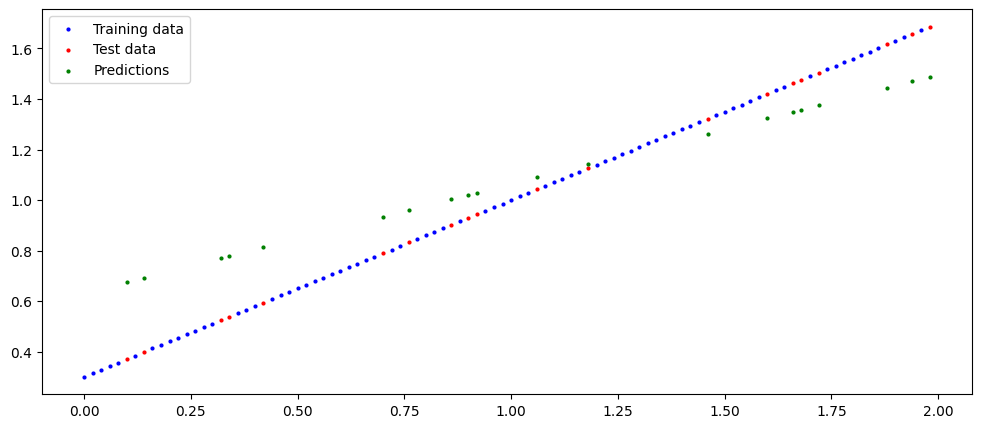

In [ ]:
plot_preds(preds=y_test_pred.cpu())

###vii) save and load trained model

In [ ]:
#save
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_PyTorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)
print('model saved successfully')

model saved successfully


In [ ]:
#load
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.4331]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.6308], device='cuda:0'))])



---

